In [ ]:
import os,sys

import ufl
import dolfin as dl

#sys.path.append(os.environ.get('HIPPYLIB_PATH'))
sys.path.append(os.environ.get('HIPPYLIB_PATH', "../../"))
import hippylib as hp
sys.path.append(os.environ.get('HIPPYFLOW_PATH'))
import hippyflow as hf

import torch

import gempy as gp
import gempy_engine
import gempy_viewer as gpv
from gempy_engine.core.backend_tensor import BackendTensor
from gempy_probability.plot_posterior import default_red, default_blue, PlotPosterior

from helpers import *
from generate_samples import *

/home/jt925938/anaconda3/envs/gempy_dino/lib/python3.10/site-packages/dolfin/jit/jit.py:121: RuntimeWarning: mpi4py.MPI.Session size changed, may indicate binary incompatibility. Expected 32 from C header, got 40 from PyObject
  def compile_class(cpp_data, mpi_comm=MPI.comm_world):
/home/jt925938/anaconda3/envs/gempy_dino/lib/python3.10/site-packages/dolfin/jit/jit.py:46: RuntimeWarning: mpi4py.MPI.Session size changed, may indicate binary incompatibility. Expected 32 from C header, got 40 from PyObject
  if MPI.size(mpi_comm) == 1:


TypeError: stat: path should be string, bytes, os.PathLike or integer, not NoneType

## Set up the gempy model

In [1]:
geo_model_test = create_initial_gempy_model_3_layer(refinement=7, save=True)

NameError: name 'create_initial_gempy_model_3_layer' is not defined

## Set up the function spaces

In [ ]:
nx = 10; ny = 10;
mesh = dl.RectangleMesh(dl.Point(0.0, 0.0), dl.Point(1.0, 1.0), nx, ny)
Vh_STATE = dl.FunctionSpace(mesh, "CG", 2)
Vh_PARAMETER = dl.FunctionSpace(mesh, "CG", 1)
Vh = [Vh_STATE, Vh_PARAMETER, Vh_STATE]


## Evaluate the gempy m on a grid

In [ ]:
loaded_array = mesh.coordinates()
#print(loaded_array)
if loaded_array.shape[1]==2:
    xyz_coord = np.insert(loaded_array, 1, 0, axis=1)
elif loaded_array.shape[1]==3:
    xyz_coord = loaded_array
gp.set_custom_grid(geo_model_test.grid, xyz_coord=xyz_coord)
geo_model_test.interpolation_options.mesh_extraction = False

Active grids: GridTypes.DENSE|CUSTOM|NONE


In [ ]:
###############################################################################
# Solve the gempy to compute the model
###############################################################################
sol = gp.compute_model(geo_model_test)
m_values = geo_model_test.solutions.octrees_output[0].last_output_center.custom_grid_values

Setting Backend To: AvailableBackends.numpy
Chunking done: 12 chunks
Chunking done: 12 chunks


## Plotting m in its pixel basis

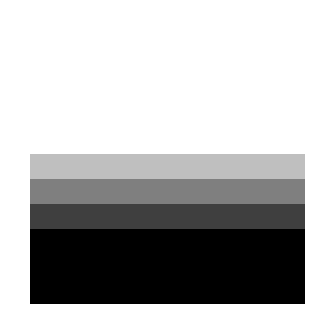

In [ ]:
plt.imshow(m_values.reshape((nx+1,ny+1)),origin = 'lower',cmap='binary')
plt.axis("off")
fig = plt.gcf()
fig.set_size_inches(1, 1)
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)


## As a function

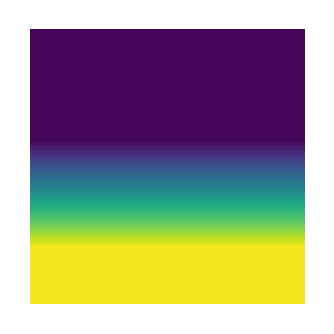

In [ ]:
d2v = dl.dof_to_vertex_map(Vh[hp.PARAMETER])
v2d = dl.vertex_to_dof_map(Vh[hp.PARAMETER])

m = dl.Function(Vh[hp.PARAMETER])
m.vector().set_local(m_values[d2v])
plt.axis("off")
dl.plot(m)
fig = plt.gcf()
fig.set_size_inches(1, 1)

## Poisson PDE

In [ ]:
def u_boundary(x, on_boundary):
    return on_boundary and ( x[1] < dl.DOLFIN_EPS or x[1] > 1.0 - dl.DOLFIN_EPS)

u_bdr = dl.Expression("x[1]", degree=1)
u_bdr0 = dl.Constant(0.0)
bc = dl.DirichletBC(Vh[hp.STATE], u_bdr, u_boundary)
bc0 = dl.DirichletBC(Vh[hp.STATE], u_bdr0, u_boundary)

f = dl.Constant(0.0)

def pde_varf(u,m,p):
    return m*ufl.inner(ufl.grad(u), ufl.grad(p))*ufl.dx - f*p*ufl.dx

pde = hp.PDEVariationalProblem(Vh, pde_varf, bc, bc0, is_fwd_linear=True)

## Instance input output observable class

In [ ]:
u_trial = dl.TrialFunction(Vh[hp.STATE])
u_test = dl.TestFunction(Vh[hp.STATE])

M_U = dl.assemble(dl.inner(u_trial,u_test)*dl.dx)

I_U = hf.StateSpaceIdentityOperator(M_U)

observable = hf.LinearStateObservable(pde,M_U)

Jm = hf.ObservableJacobian(observable)

## Sensitivities of m wrt coefficients

Suppose $m$ is a function of some finite dimensional coefficients $c \in \mathbb{R}^{d_c}$

Deep, please extract the matrix 

$$ \frac{dm}{dc} \in \mathbb{R}^{d_M\times d_c} $$

Then we can get the Jacobian with respect to $c$ as 

$$ \frac{du}{dc} = \frac{du}{dm}\frac{dm}{dc} = - \left[\frac{\partial R}{\partial u}\right]^{-1}\frac{\partial R}{\partial m} \frac{dm}{dc} $$

In [ ]:
dM = m_values.shape[0]
dc = 2
cs = np.random.rand(dc)

In [ ]:
cs_torch = torch.tensor(cs)

In [ ]:
sp_coords_copy_test = geo_model_test.interpolation_input.surface_points.sp_coords.copy()
###############################################################################
# Make a list of gempy parameter which would be treated as a random variable
###############################################################################
dtype =torch.float64
test_list=[]
test_list.append({"update":"interface_data","id":torch.tensor([1]), "direction":"Z", "prior_distribution":"normal","normal":{"mean":torch.tensor(sp_coords_copy_test[1,2],dtype=dtype), "std":torch.tensor(0.06,dtype=dtype)}})
test_list.append({"update":"interface_data","id":torch.tensor([4]), "direction":"Z", "prior_distribution":"normal","normal":{"mean":torch.tensor(sp_coords_copy_test[4,2],dtype=dtype), "std":torch.tensor(0.06,dtype=dtype)}})

num_layers = len(test_list) # length of the list

Gempy = GempyModel(test_list, geo_model_test, num_layers, dtype=torch.float64)

c = Gempy.GenerateInputSamples(number_samples=1)
m_data, dmdc_data = Gempy.GenerateOutputSamples(Inputs_samples=c)

In [ ]:
# Pretending this random vector is the dm/dc Jacobian.
dmdc = np.random.randn(dM,dc)

In [ ]:
# Compute the action of Jm on dm/dc one column at a time:

# First we need to solve and set the linearization point:

u = dl.Function(Vh[hp.STATE])
uadj = dl.Function(Vh[hp.ADJOINT])
x = [u.vector(),m.vector(),uadj.vector()]

# x = [pde.generate_state(),pde.generate_parameter(),None]
# x[hp.PARAMETER].zero()
# x[hp.PARAMETER].axpy(1,m.vector())

pde.solveFwd(x[hp.STATE], x)

Jm.observable.setLinearizationPoint(x)

uhat = dl.Function(Vh[hp.STATE])
mhat = dl.Function(Vh[hp.PARAMETER])

dU = uhat.vector().get_local().shape[0]
Jc = np.zeros((dU,dc))

for i in range(dc):
    mhat.vector().set_local(dmdc[:,i])
    Jm.mult(mhat.vector(),uhat.vector())
    Jc[:,i] = uhat.vector().get_local()


## Plot some output sensitivities

In [ ]:

for i in range(dc):
    uhat.vector().zero()
    print(80*'#')
    print('Mode ',i)
    uhat.vector().set_local(Jc[:,i])
    plt.axis("off")
    dl.plot(m)
    fig = plt.gcf()
    fig.set_size_inches(1, 1)
    plt.show()